In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv('Online_Retail.csv')

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate total price
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# Drop missing CustomerIDs
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)


In [4]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalAmount': 'sum'                                      # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
})

# Add AOV
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

# Target: CLV = average monthly spend × predicted lifespan (we’ll use total spend as proxy)
rfm['CLV'] = rfm['Monetary']


In [5]:
X = rfm[['Recency', 'Frequency', 'AOV']]
y = rfm['CLV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [7]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')


MAE: 54.41
RMSE: 324.72


In [8]:
rfm['Predicted_CLV'] = model.predict(X)

# Segment
rfm['Segment'] = pd.qcut(rfm['Predicted_CLV'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])


In [9]:
rfm.reset_index()[['CustomerID', 'Recency', 'Frequency', 'AOV', 'Predicted_CLV', 'Segment']].to_csv('predicted_clv.csv', index=False)


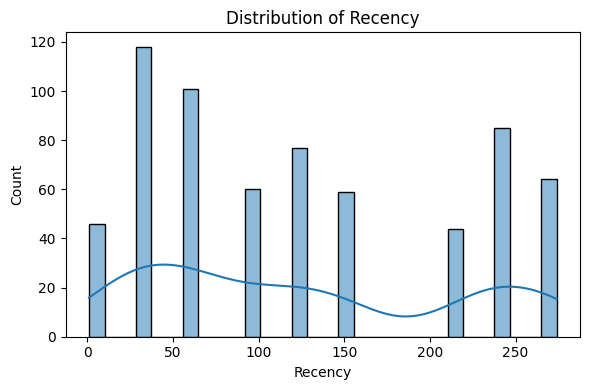

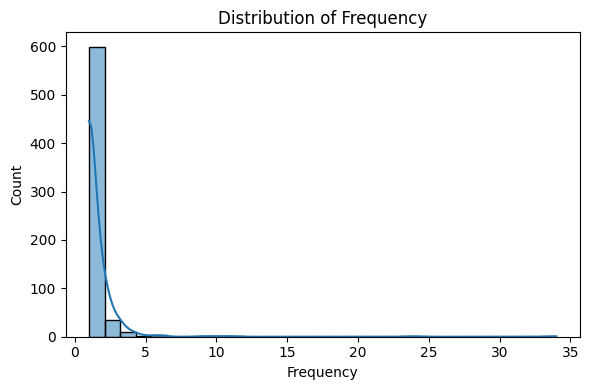

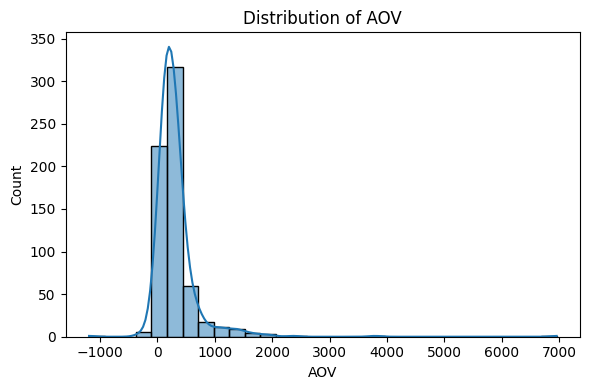

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['Recency', 'Frequency', 'AOV']

for col in features:
    plt.figure(figsize=(6,4))
    sns.histplot(rfm[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


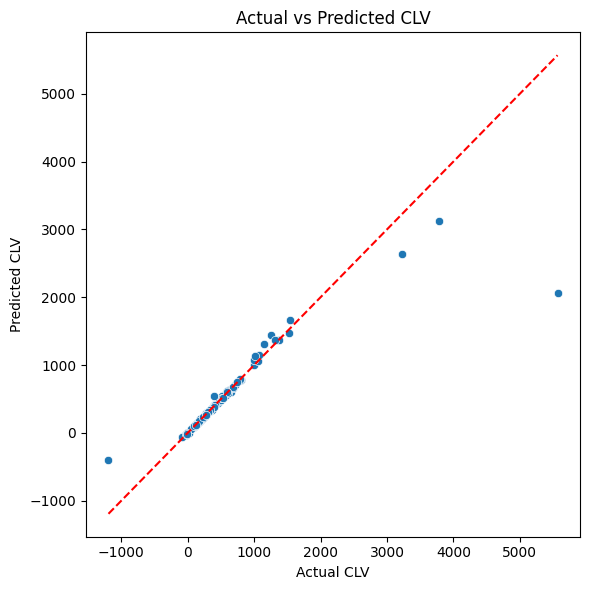

In [11]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Actual vs Predicted CLV')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Diagonal line
plt.tight_layout()
plt.show()


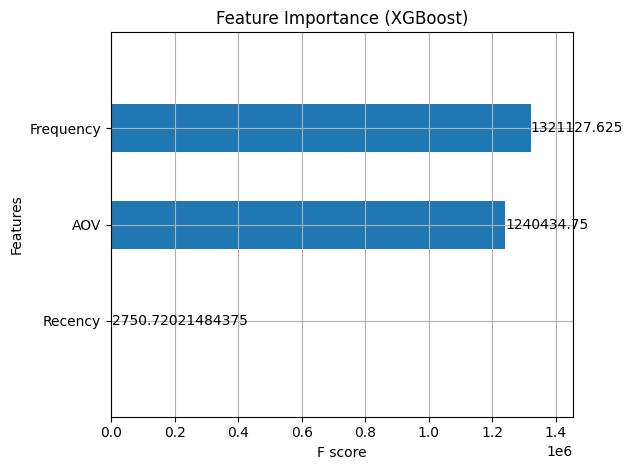

In [12]:
#feature importance
xgb.plot_importance(model, importance_type='gain', height=0.5)
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()


<ipython-input-13-3742058540>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Segment', data=rfm, order=['Low', 'Medium', 'High', 'Very High'], palette='coolwarm')


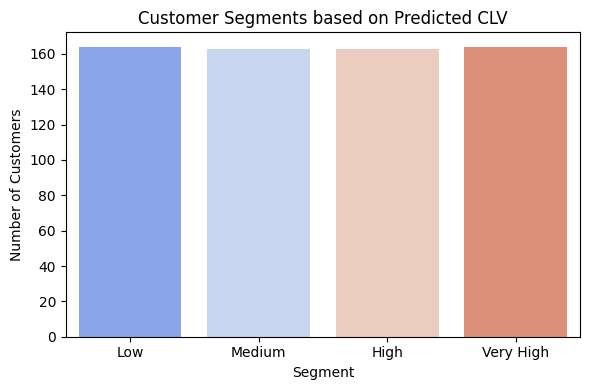

In [13]:
#Visualize how many customers fall into each predicted segment
plt.figure(figsize=(6,4))
sns.countplot(x='Segment', data=rfm, order=['Low', 'Medium', 'High', 'Very High'], palette='coolwarm')
plt.title('Customer Segments based on Predicted CLV')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


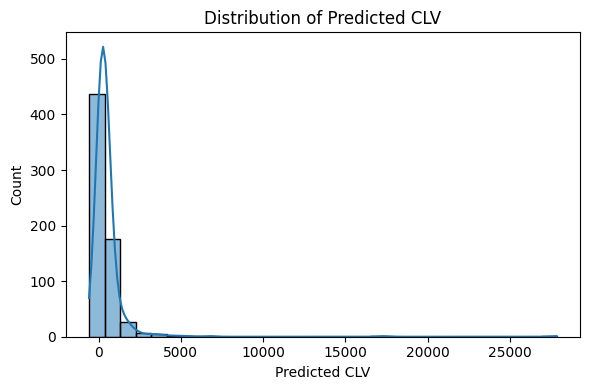

In [14]:
#CLV Distribution Histogram
plt.figure(figsize=(6,4))
sns.histplot(rfm['Predicted_CLV'], kde=True, bins=30)
plt.title('Distribution of Predicted CLV')
plt.xlabel('Predicted CLV')
plt.tight_layout()
plt.show()



In [16]:
st.subheader("📉 Predicted CLV by Customer Segment")

fig6, ax6 = plt.subplots(figsize=(8, 4))
sns.boxplot(data=filtered, x='Segment', y='Predicted_CLV', order=sorted(rfm["Segment"].unique()), palette="Set3", ax=ax6)
ax6.set_title("CLV Distribution Across Segments")
st.pyplot(fig6)


NameError: name 'st' is not defined

In [15]:
#save model
import joblib
joblib.dump(model, '.pkl')


['CLV_model.pkl']